<a href="https://colab.research.google.com/github/audreyemmely/pln/blob/main/pln_lista6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resolução Lista 6**

---

Audrey Emmely Rodrigues Vasconcelos

Karen Nayara Gomes da Silva

In [1]:
#from google.colab import files
#uploaded = files.upload()
#upando train_data e test_data_solution

In [2]:
import pandas as pd
import numpy as np
import spacy
import random
import nltk
import re
from matplotlib import pyplot as plt
import pathlib
import string
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [4]:
df = pd.read_csv('train_data.txt', sep =':::', header = None, engine = 'python', nrows = 300)
df.columns = ['id', 'title', 'genre', 'description']
df2 = pd.read_csv('test_data_solution.txt', sep =':::', header = None, engine = 'python', nrows = 300)
df2.columns = ['id', 'title', 'genre', 'description']

In [5]:
df3 = pd.concat([df, df2], ignore_index=True)
df3.drop('id', axis=1, inplace=True)
comedy = df3.loc[df3['genre'].str.contains('comedy')]
drama = df3.loc[df3['genre'].str.contains('drama')]
dataset = pd.concat([comedy, drama], ignore_index=True)

In [6]:
def preprocess(description):
  description = re.sub(r'\w*\d\w*', '', description) #remove todas as palavras que contêm números
  description = re.sub(r'[^a-zA-Z ]', '', description.lower())
  return re.sub(r'\s+', ' ', description) #retira espaços repetidos

In [7]:
dataset['processed_description'] = dataset.description.apply(preprocess)

In [8]:
stop_words = set(nltk.corpus.stopwords.words('english'))
def remove_stopwords(description):
    tokenized_text = nltk.word_tokenize(description, language='english')
    return " ".join([token for token in tokenized_text if token not in stop_words])

In [9]:
dataset['processed_description_stop'] = dataset.processed_description.apply(remove_stopwords)

In [10]:
dataset

,title,genre,description,processed_description,processed_description_stop
0,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,in tough economic times max and joey have all...,tough economic times max joey run ideas discov...
1,Babylon Vista (2001),comedy,Frankie Reno was a child star on a TV show. B...,frankie reno was a child star on a tv show bu...,frankie reno child star tv show thirty years a...
2,Söderpojkar (1941),comedy,A gang of unemployed itinerant musicians play...,a gang of unemployed itinerant musicians play...,gang unemployed itinerant musicians play south...
3,Tunnel Vision (1976),comedy,A committee investigating TV's first uncensor...,a committee investigating tvs first uncensore...,committee investigating tvs first uncensored n...
4,"""The Young Professionals"" (2015)",comedy,"Whether it's blocking up mouse holes, running...",whether its blocking up mouse holes running f...,whether blocking mouse holes running landlords...
...,...,...,...,...,...
230,Future Weather (2012),drama,"When her single mom runs off to California, L...",when her single mom runs off to california la...,single mom runs california lauduree passionate...
231,Six Minutes to Midnight (????),drama,Summer 1939. Influential families in Nazi Ger...,summer influential families in nazi germany h...,summer influential families nazi germany sent ...
232,Jeunes filles en détresse (1939),drama,Jacqueline is sixteen. Her parents are kept v...,jacqueline is sixteen her parents are kept ve...,jacqueline sixteen parents kept busy mutual ca...
233,Silence (2013/XI),drama,'Silence' is an intimate portrait of the life...,silence is an intimate portrait of the life o...,silence intimate portrait life ten year old gi...


## Questão 1
Resolva novamente a segunda questão da 3a lista usando pelo menos duas arquiteturas de redes neurais que utilizem camadas Embedding, convolucionais e 
LSTM. Compare com os resultados obtidos anteriormente nas lista 3 e 5.

## Questão 2
Usando sua base de textos:

a) Treine uma rede LSTM para gerar texto, que receba uma ou mais palavras
de uma frase como entrada. O treinamento deve ser realizado considerando
um conjunto supervisionado que gera a próxima palavra de uma sequência
de tamanho 4, usando subsequências de sua base.

b) Após o treinamento, exiba pelo menos 5 exemplos de textos dados de entrada, e do texto gerado em seguida pela rede treinada. Para cada exemplo, gere pelo menos 10 palavras consecutivamente.

In [11]:
tokenizer = Tokenizer()
def get_sequence_of_tokens(description):
    ## tokenization
    tokenizer.fit_on_texts(dataset.processed_description)
    total_words = len(tokenizer.word_index) + 1

    input_sequences = []
    for line in description:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(dataset.processed_description)

In [12]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [13]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 10, input_length=input_len))
  
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 660, 10)           57310     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 5731)              578831    
                                                                 
Total params: 680,541
Trainable params: 680,541
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(predictors, label, epochs=11, verbose=1)

Epoch 1/11
750/750 [==============================] - 454s 597ms/step - loss: 7.2160
Epoch 2/11
750/750 [==============================] - 425s 567ms/step - loss: 6.7974
Epoch 3/11
750/750 [==============================] - 440s 586ms/step - loss: 6.6510
Epoch 4/11
750/750 [==============================] - 413s 551ms/step - loss: 6.4953
Epoch 5/11
750/750 [==============================] - 418s 558ms/step - loss: 6.3433
Epoch 6/11
750/750 [==============================] - 414s 553ms/step - loss: 6.2013
Epoch 7/11
750/750 [==============================] - 412s 549ms/step - loss: 6.0516
Epoch 8/11
750/750 [==============================] - 412s 549ms/step - loss: 5.8795
Epoch 9/11
750/750 [==============================] - 416s 554ms/step - loss: 5.7024
Epoch 10/11
750/750 [==============================] - 413s 551ms/step - loss: 5.5229
Epoch 11/11
750/750 [==============================] - 412s 549ms/step - loss: 5.3551


In [15]:
def generate_text(seed_text, next_words, model, max_sequence_len): 
    #seed_text: string para teste, next_word: qtdd de palavras q quer prever, max_sequence_len: contagem max de seq usada durante o treinamento
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        #predicted = model.predict_classes(token_list, verbose=0)
        predicted = model.predict(token_list) 
        classes = np.argmax(predicted,axis=1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == classes:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [16]:
print (generate_text("frankie reno was a child", 4, model, max_sequence_len))

Frankie Reno Was A Child Of A Young Man


In [17]:
print (generate_text("whether its blocking up", 10, model, max_sequence_len))
print (generate_text("science and technology", 10, model, max_sequence_len))
print (generate_text("awake from a deep sleep", 10, model, max_sequence_len))
print (generate_text("first film", 10, model, max_sequence_len))
print (generate_text("the sydney opera house", 10, model, max_sequence_len))

Whether Its Blocking Up A Story Of A Young Man Of The Young Company
Science And Technology To A Story Of A Young Man Of The World
Awake From A Deep Sleep Of The New World Of The Slack Company In The
First Film A Story Of A Young Man Of The World Of
The Sydney Opera House In A Russian Man In The New World Of The


## Questão 3
Usando sua base de textos e a biblioteca spaCy, realize as seguintes tarefas:

a) Extraia as etiquetas gramaticais (POS) de cada token do seu textos.

b) Calcule e plote um gráfico com as frequências de cada tipo gramatical.

c) Extraia entidades do tipo pessoa e lugar dos seus textos.

d) Identifique e liste as pessoas mais frequentes nos seus textos. Você só deve contar cada entidade 1 vez por documento.

In [18]:
nlp = spacy.load("en_core_web_sm")

In [19]:
processed_description_list = list(dataset['processed_description_stop'].values)

In [20]:
token_pos = []

for phrase in processed_description_list:
    doc = nlp(phrase)

    for token in doc:        
        token_pos.append(token.pos_)

token_pos[:20]

['ADJ',
 'PROPN',
 'NOUN',
 'PROPN',
 'PROPN',
 'PROPN',
 'NOUN',
 'VERB',
 'ADJ',
 'NOUN',
 'ADJ',
 'PROPN',
 'NOUN',
 'VERB',
 'NOUN',
 'NUM',
 'VERB',
 'CCONJ',
 'ADJ',
 'NOUN']

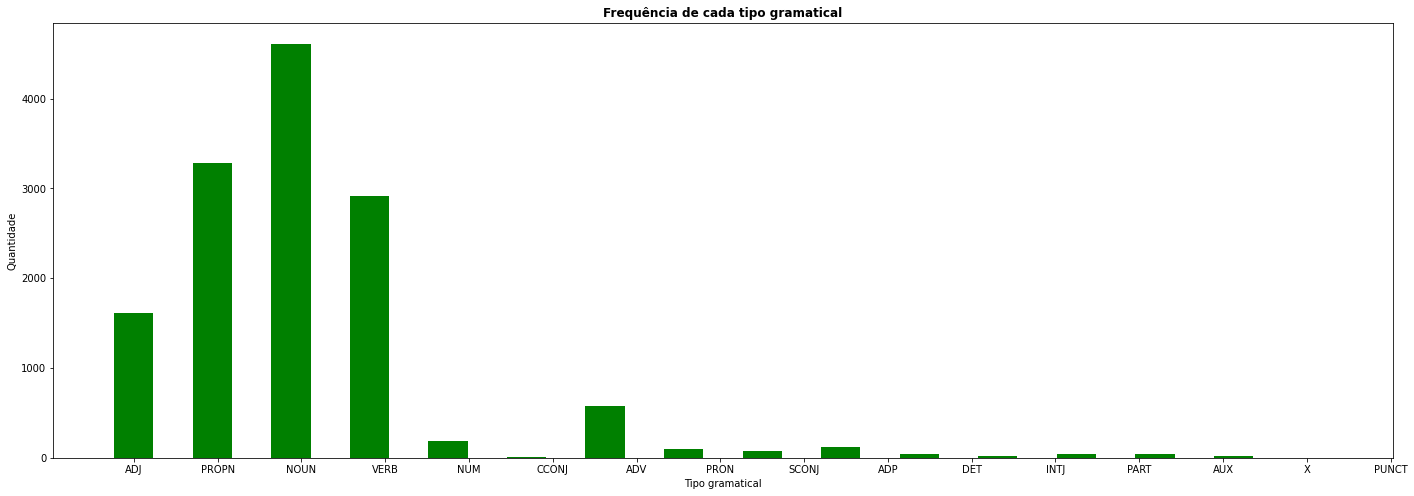

In [21]:
plt.figure(figsize=(24,8))
plt.hist(token_pos, bins=16, rwidth=0.5, align='left', color='green')

plt.xlabel('Tipo gramatical')
plt.ylabel('Quantidade')
  
plt.title('Frequência de cada tipo gramatical',
          fontweight ="bold")
  
plt.show()

In [22]:
entities_person_gpe = []
persons = {}
entities_to_search = ['PERSON', 'GPE']

for phrase in processed_description_list:
    doc = nlp(phrase)

    for entity in doc.ents:
      entity_persons_in_doc = []

    if entity.label_ in entities_to_search:
      entities_person_gpe.append((entity.text, entity.label_))
      
      if entity.label_ == 'PERSON':
          entity_persons_in_doc.append(entity.text)
      
      unique_persons = list(set(entity_persons_in_doc))
      
      for unique_person in unique_persons:
        if unique_person in persons.keys():
          persons[unique_person] += 1
        else:
          persons[unique_person] = 1

In [23]:
entities_person_gpe[:20]

[('hollywood', 'GPE'),
 ('astrakhan maurice', 'PERSON'),
 ('las vegas', 'GPE'),
 ('eve', 'PERSON'),
 ('herbert marshall', 'PERSON'),
 ('kenny doug', 'PERSON'),
 ('theatre company', 'PERSON'),
 ('standup comedy favorite', 'PERSON'),
 ('sleepy joe', 'PERSON'),
 ('mum struggles', 'PERSON'),
 ('irene falls young ronald', 'PERSON'),
 ('kim', 'PERSON'),
 ('hollywood', 'GPE'),
 ('standup', 'PERSON'),
 ('john michael', 'PERSON'),
 ('monte cristo', 'PERSON'),
 ('susan', 'PERSON'),
 ('sicilia', 'GPE'),
 ('sicilia', 'GPE'),
 ('joe', 'PERSON')]

In [24]:
get_entities = list([ent[1] for ent in entities_person_gpe])

[(entity, get_entities.count(entity)) for entity in set(get_entities)]

[('GPE', 25), ('PERSON', 76)]

In [25]:
most_frequent_persons = [(key, value) for key, value in persons.items()]
most_frequent_persons.sort(key= lambda person : person[1], reverse=True)
most_frequent_persons[:10]

[('simon', 4),
 ('rani', 2),
 ('minas gerais', 2),
 ('rick jos young pierrot', 2),
 ('astrakhan maurice', 1),
 ('eve', 1),
 ('herbert marshall', 1),
 ('kenny doug', 1),
 ('theatre company', 1),
 ('standup comedy favorite', 1)]

## Questão 4
Estude o tutorial *Character-level recurrent sequence-to-sequence model* disponível em https://keras.io/examples/nlp/lstm_seq2seq/.

a) Treine um outro modelo de tradução entre línguas distintas e exiba 5 exemplos de tradução de frases curtas. Você pode encontrar conjuntos de treinamento em http://www.manythings.org/anki/.

b) BONUS: Adapte o código para realizar tradução com uma rede *word-level*.


In [26]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


In [27]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [28]:
for _ in range(5):
    print(random.choice(text_pairs))

("I'll remember you forever.", '[start] Siempre me acordaré de ti. [end]')
('He always leaves the window open while he sleeps.', '[start] Siempre deja la ventana abierta mientras duerme. [end]')
('I want you to leave my house.', '[start] Quiero que te vayas de mi casa. [end]')
("I've been waiting for two hours.", '[start] Llevo dos horas esperando. [end]')
('He wiped the sweat from his forehead.', '[start] Él se secó el sudor de su frente. [end]')


**Vetorizar os dados**

In [29]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [30]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [31]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


**Construir o modelo**

In [32]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [33]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")

**Treinando o modelo**

In [ ]:
# demorou cerca de 1 hora pra rodar (por causa do epochs)
transformer.summary()
transformer.compile("rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer.fit(train_ds, epochs=1, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

**Decodifica as sentanças**

In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))

def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(20):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence.replace('[start] ', '').replace(' [end]', '')


test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(5):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(str(i + 1) + '.')
    print('Input sentence:', input_sentence)
    print('Decoded sentence:', translated)

**Referências**

[Beginners Guide to Text Generation using LSTMs](https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms)

[English-to-Spanish translation with a sequence-to-sequence Transformer](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)